In [1]:
import os
os.chdir("/home/ubuntu/code/pump_post_midterm/pump")

import json
import bnlearn as bn
import pandas as pd
import networkx as nx
import copy
from tqdm import tqdm


In [2]:
# persona_filename = 'opinions_qa/persona_val/American_Trends_Panel_W26/date0729_midterm_personas_full_sonnet.json'
# persona_filename = 'opinions_qa/persona_val/American_Trends_Panel_W26/date0828_personas_American_Trends_Panel_W26_testonly_haiku.json'
persona_filename = 'opinions_qa/persona_val/American_Trends_Panel_W26/date0828_personas_American_Trends_Panel_W26_testonly_haiku.json'

with open(persona_filename, 'r') as f:
    data = json.load(f)
data[list(data.keys())[0]]

[{'name': 'Personal Values Regarding Firearms',
  'description': "The participant's core values and beliefs that shape their attitudes and behaviors towards firearm ownership, use, and safety, such as personal freedom, public safety, self-reliance, and responsible gun ownership.",
  'level': 'high',
  'candidate_values': ['values personal freedom',
   'values public safety',
   'values self-reliance and personal protection',
   'values responsible gun ownership'],
  'inferred_value': 'values public safety'},
 {'name': 'Attitudes Towards Firearms',
  'description': "The participant's overall beliefs, opinions, and feelings about guns and their role in society, including views on gun ownership, gun control, and the broader cultural attitudes towards firearms.",
  'level': 'high',
  'candidate_values': ['pro-gun', 'anti-gun', 'neutral'],
  'inferred_value': 'anti-gun'},
 {'name': 'Personality Traits',
  'description': "The participant's general disposition, including their level of anxiet

# Data Preprocessing

In [3]:
# verify data

def verify(data):
    ok_cnt = 0
    wrong_cnt = 0
    for user in data:
        for persona in data[user]:
            # if all(_ not in persona['candidate_values'] for _ in [persona['inferred_value'], persona['inferred_value'][1:-1]]):
            if persona['inferred_value'] not in persona['candidate_values']:
                wrong_cnt += 1
                print(persona)
                print(f"|{persona['inferred_value']}|")
                print(persona['candidate_values'])
                print()
            else:
                ok_cnt += 1

    print(ok_cnt, wrong_cnt)

verify(data)

{'name': 'Firearm Ownership Motivations', 'description': 'The primary reasons and purposes for owning firearms, such as hunting, self-defense, sport shooting, or collecting.', 'level': 'mid', 'candidate_values': ['hunting', 'self-defense', 'sport shooting', 'collection', 'other'], 'inferred_value': 'no guns'}
|no guns|
['hunting', 'self-defense', 'sport shooting', 'collection', 'other']

{'name': 'Perception of Crime Trends', 'description': 'How the participant perceives the overall level of crime and safety in the world compared to the past, which may shape their views on gun ownership.', 'level': 'mid', 'candidate_values': ['world is safer', 'world is more dangerous', 'world is neither safer nor more dangerous'], 'inferred_value': 'more dangerous'}
|more dangerous|
['world is safer', 'world is more dangerous', 'world is neither safer nor more dangerous']

{'name': 'Firearm Ownership Motivations', 'description': 'The primary reasons and purposes for owning firearms, such as hunting, s

In [4]:
# clean data

def clean(data):
    temp_data = copy.deepcopy(data)
    for user in data.keys():
        personas = data[user]
        clean = []
        seen_personas = []
        for p in personas:
            if f"{p['level']}/{p['name']}" in seen_personas:
                continue
            inf_val = p['inferred_value']
            cands = p['candidate_values']
            if len(cands) > 5:
                continue
            if inf_val not in cands:
                if inf_val[1:-1] in cands and all(_ in ['\'', '\"'] for _ in [inf_val[0], inf_val[-1]]):
                    p['inferred_value'] = inf_val[1:-1]
                    clean.append(p)
                    seen_personas.append(f"{p['level']}/{p['name']}")
            else:
                clean.append(p)
                seen_personas.append(f"{p['level']}/{p['name']}")
        temp_data[user] = clean
    return temp_data

cleaned_data = clean(data)
verify(cleaned_data)

38831 0


In [5]:
for user in cleaned_data:
    for idx, p in enumerate(cleaned_data[user]):
        if p['inferred_value'] not in p['candidate_values']:
            print(user, idx, p['name'], p['inferred_value'], p['candidate_values'], p)

len(set([f"{p['level']}/{p['name']}" for user in cleaned_data for p in cleaned_data[user]]))

100

In [6]:
cleaned_data['2820']

[{'name': 'Personal Values Regarding Firearms',
  'description': "The participant's core values and beliefs that shape their attitudes and behaviors towards firearm ownership, use, and safety, such as personal freedom, public safety, self-reliance, and responsible gun ownership.",
  'level': 'high',
  'candidate_values': ['values personal freedom',
   'values public safety',
   'values self-reliance and personal protection',
   'values responsible gun ownership'],
  'inferred_value': 'values public safety'},
 {'name': 'Attitudes Towards Firearms',
  'description': "The participant's overall beliefs, opinions, and feelings about guns and their role in society, including views on gun ownership, gun control, and the broader cultural attitudes towards firearms.",
  'level': 'high',
  'candidate_values': ['pro-gun', 'anti-gun', 'neutral'],
  'inferred_value': 'anti-gun'},
 {'name': 'Personality Traits',
  'description': "The participant's general disposition, including their level of anxiet

In [7]:
# categorize_data

idx2opt_mapping = {}
opt2idx_mapping = {}

for user in cleaned_data:
    for persona in cleaned_data[user]:
        p_name = f"{persona['level']}/{persona['name']}"
        if p_name in idx2opt_mapping:
            continue
        cands = persona['candidate_values']
        idx2opt = {k+1: v for k, v in enumerate(cands)}  # 0 for potential NAs
        idx2opt[0] = "Unknown"
        idx2opt_mapping[p_name] = idx2opt
        opt2idx_mapping[p_name] = {v: k for k, v in idx2opt.items()}



In [8]:
def categorize(data):
    categorized_data = copy.deepcopy(data)
    for user in data:
        personas = data[user]
        clean = []
        for idx, p in enumerate(personas):
            p_name = f"{p['level']}/{p['name']}"
            inf_val = p['inferred_value']
            try:
                p['inferred_value'] = opt2idx_mapping[p_name][inf_val]
            except:
                print(user, p_name, idx, inf_val)
                # print(p_name, p_name in opt2idx_mapping)
                # print(inf_val, inf_val in opt2idx_mapping[p_name])
                # print(opt2idx_mapping[p_name])
                print(p)
            clean.append(p)
        categorized_data[user] = clean
    return categorized_data

categorized_data = categorize(cleaned_data)

In [9]:
res = []

for user in categorized_data.keys():
    entry = {'user': user}
    for persona in categorized_data[user]:
        entry[f"{persona['level']}/{persona['name']}"] = persona['inferred_value']
    res.append(entry)

raw_df = pd.DataFrame(res)
raw_df.fillna(0, inplace=True)
raw_df = raw_df.astype(int)
df = raw_df[[_ for _ in raw_df.columns if _ is not "user"]]
df

high/Personal Values Regarding Firearms  high/Attitudes Towards Firearms  \
0                                          2                                2   
1                                          2                                2   
2                                          2                                2   
3                                          3                                1   
4                                          4                                3   
..                                       ...                              ...   
389                                        2                                2   
390                                        2                                2   
391                                        2                                2   
392                                        4                                3   
393                                        4                                2   

     high/Personality Traits  \
0                          1   
1                          2   
2                          2   
3                          2   
4                          1   
..                       ...   
389                        1   
390                        2   
391                        2   
392                        2   
393                        1   

     high/Cultural and Social Influences on Firearm Attitudes  \
0                                                    3          
1                                                    3          
2                                                    2          
3                                                    1          
4                                                    3          
..                                                 ...          
389                                                  3          
390                                                  3          
391                                                  3          
392                                                  3          
393                                                  3          

     high/Prioritization of Child Safety  high/Risk Tolerance  \
0                                      1                    2   
1                                      2                    2   
2                                      1                    2   
3                                      2                    1   
4                                      1                    2   
..                                   ...                  ...   
389                                    1                    2   
390                                    1                    2   
391                                    1                    2   
392                                    2                    2   
393                                    2                    2   

     high/Sense of Safety  high/Socioeconomic Status  \
0                       2                          2   
1                       2                          2   
2                       2                          1   
3                       2                          2   
4                       2                          2   
..                    ...                        ...   
389                     2                          2   
390                     2                          1   
391                     2                          2   
392                     2                          2   
393                     2                          2   

     high/Worldview and Beliefs  high/Locus of Control  ...  \
0                             3                      2  ...   
1                             3                      2  ...   
2                             3                      2  ...   
3                             3                      2  ...   
4                             3                      2  ...   
..                          ...   

# Creating BN

In [10]:

# def get_bn(df, method, score):

#     model = bn.structure_learning.fit(df, methodtype=method, scoretype=score, tabu_length=100)
#     # Plot detected DAG
#     pos = nx.spring_layout(model['adjmat'])
#     G = bn.plot(model, pos=pos)
#     dirs = []
#     for edge in G['edge_properties']:
#         s, t = edge
#         s = s.split('/')[0]
#         t = t.split('/')[0]
#         dirs.append(f"{s}_{t}")
#     from collections import Counter
#     sorted(Counter(dirs).items())


#     # Compute edge strength using chi-square independence test
#     model1 = bn.independence_test(model, df, alpha=0.05, prune=True)
#     pos = nx.spring_layout(model['adjmat'])
#     G1 = bn.plot(model, pos=pos)
#     dirs = []
#     for edge in G1['edge_properties']:
#         s, t = edge
#         s = s.split('/')[0]
#         t = t.split('/')[0]
#         dirs.append(f"{s}_{t}")
#     from collections import Counter
#     sorted(Counter(dirs).items())


#     param_model = bn.parameter_learning.fit(model1, df)

#     return param_model


[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bds]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model
[bnlearn] >Existing coordinates from <pos> are used.


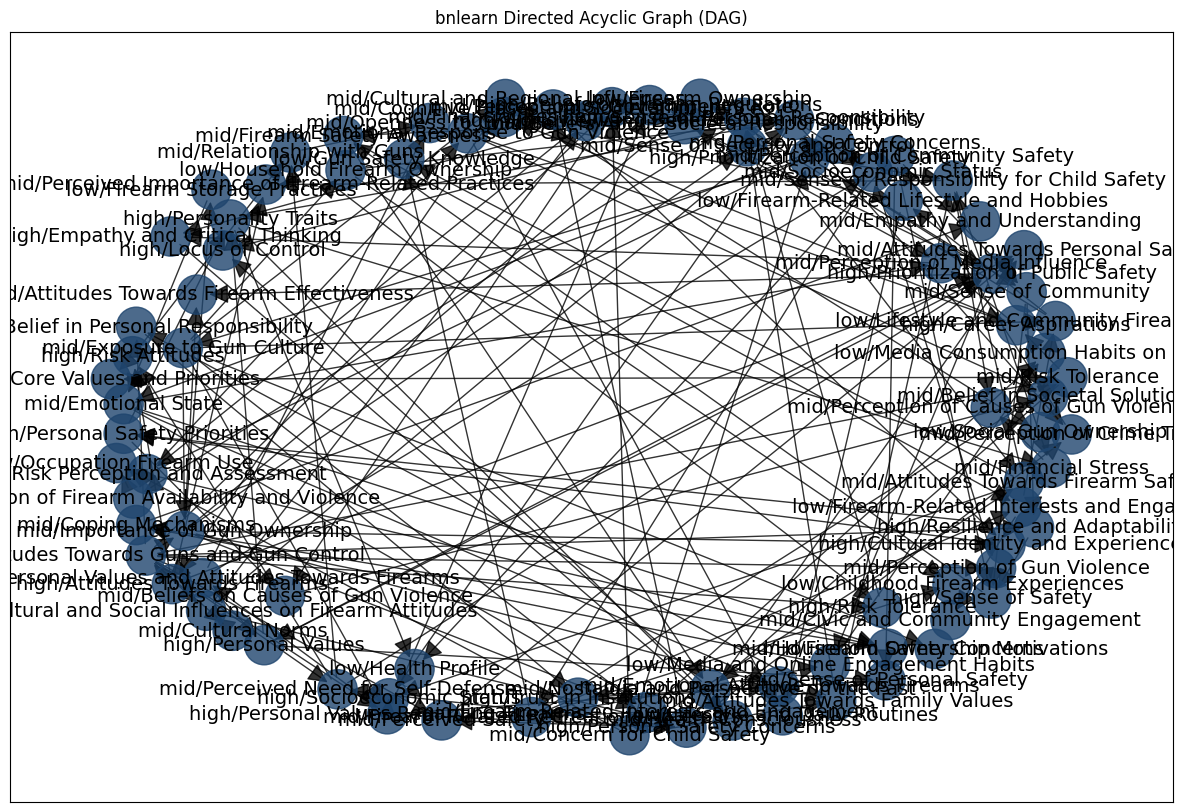

[bnlearn] >Compute edge strength with [chi_square]
[bnlearn] >Edge [high/Personal Safety Priorities <-> mid/Beliefs on Causes of Gun Violence] [P=0.0856534] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [high/Beliefs on Firearm Regulations <-> mid/Emotional Response to Gun Violence] [P=0.0923096] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [mid/Concern for Child Safety <-> mid/Attitudes Towards Family Values] [P=0.4889] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [mid/Concern for Child Safety <-> low/Occupation Firearm Use] [P=0.429678] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [mid/Belief in Personal Responsibility <-> high/Trust in Institutions] [P=0.166565] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [mid/Coping Mechanisms <-> mid/Empathy and Understanding] [P=1] is excluded b

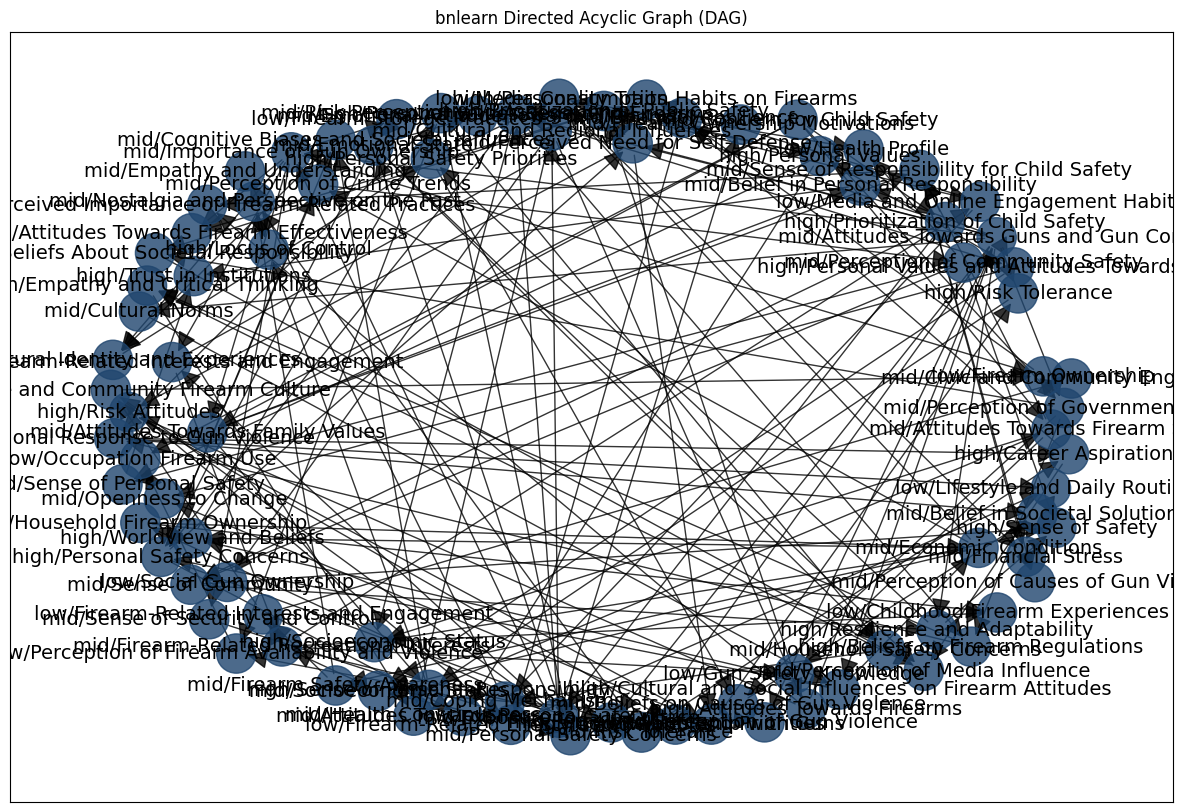

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of high/Personal Values Regarding Firearms:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of high/Socioeconomic Status:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of high/Personal Values and Attitudes Towards Firearms:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of high/Personal Safety Concerns:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of high/Beliefs on Firearm Regulations:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of mid/Emotional Attitude Towards Firearms:
+-----+
| ... |
+-----+
| ... |
+-----+
| ..

In [11]:

method = 'hc'
score = 'bds'

model = bn.structure_learning.fit(df, methodtype=method, scoretype=score, tabu_length=100)
# Plot detected DAG
pos = nx.spring_layout(model['adjmat'])
G = bn.plot(model, pos=pos)
dirs = []
for edge in G['edge_properties']:
    s, t = edge
    s = s.split('/')[0]
    t = t.split('/')[0]
    dirs.append(f"{s}_{t}")
from collections import Counter
sorted(Counter(dirs).items())


# Compute edge strength using chi-square independence test
model1 = bn.independence_test(model, df, alpha=0.05, prune=True)
pos = nx.spring_layout(model['adjmat'])
G1 = bn.plot(model, pos=pos)
dirs = []
for edge in G1['edge_properties']:
    s, t = edge
    s = s.split('/')[0]
    t = t.split('/')[0]
    dirs.append(f"{s}_{t}")
from collections import Counter
sorted(Counter(dirs).items())


param_model = bn.parameter_learning.fit(model1, df)



In [61]:
Counter(dirs)

Counter({'mid_mid': 56,
         'high_mid': 31,
         'mid_high': 31,
         'high_high': 20,
         'mid_low': 17,
         'low_low': 7,
         'low_mid': 5,
         'high_low': 3})

In [65]:

def get_matrix(dirs):

    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns

    # Define the confusion matrix data
    data = Counter(dirs)

    # Create a confusion matrix array
    matrix = np.array([
        [data['high_high'], data['high_mid'], data['high_low']],
        [data['mid_high'], data['mid_mid'], data['mid_low']],
        [data['low_high'] if 'low_high' in data else 0, data['low_mid'], data['low_low']]
    ])

    # Define the labels for the axes
    labels = ['high', 'mid', 'low']

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Target')
    plt.ylabel('Source')
    plt.title('Edge source target matrix')
    plt.show()


In [66]:
def get_topo(model):

    import matplotlib.pyplot as plt
    import networkx as nx

    adjmat_df = model['adjmat']
    adjmat_numeric_df = adjmat_df.astype(int)
    G = nx.from_pandas_adjacency(adjmat_numeric_df, create_using=nx.DiGraph)

    topological_sorted_nodes = list(nx.topological_sort(G))
    pos = {node: (i, 0) for i, node in enumerate(topological_sorted_nodes)}

    plt.figure(figsize=(250, 30))

    # Define a color map based on node names
    node_colors = []
    for node in G.nodes:
        if node.startswith('low/'):
            node_colors.append('pink')
        elif node.startswith('mid/'):
            node_colors.append('gold')
        elif node.startswith('high/'):
            node_colors.append('lightblue')
        else:
            node_colors.append('lightblue')  # Default color

    # Draw the graph with node colors
    nx.draw(
        G, pos, 
        with_labels=False, 
        node_size=3000, 
        node_color=node_colors,  # Use the custom color map
        font_size=10, 
        font_weight='bold', 
        arrowsize=20, 
        connectionstyle='arc3,rad=0.2'  # Add this line to create curved arrows
    )

    # Annotate the nodes with their labels
    for label in pos:
        x, y = pos[label]
        plt.text(x, y, s=label, bbox=dict(facecolor='lightgray', alpha=0.5), 
                horizontalalignment='center', fontsize=8, rotation=15)

    plt.title("Bayesian Network with Topological Sort Layout")
    plt.show()



In [11]:
len(set(df.columns))

100

In [25]:
model['adjmat']

target                                             high/Personal Values Regarding Firearms  \
source                                                                                       
high/Personal Values Regarding Firearms                                              False   
high/Attitudes Towards Firearms                                                      False   
high/Personality Traits                                                              False   
high/Cultural and Social Influences on Firearm ...                                   False   
high/Prioritization of Child Safety                                                  False   
...                                                                                    ...   
low/Media Consumption Habits on Firearms                                             False   
low/Perception of Firearm Availability and Viol...                                   False   
low/Lifestyle and Community Firearm Culture                                          False   
mid/Firearm Ownership Motivations                                                    False   
mid/Perception of Crime Trends                                                       False   

target                                             high/Attitudes Towards Firearms  \
source                                                                               
high/Personal Values Regarding Firearms                                      False   
high/Attitudes Towards Firearms                                              False   
high/Personality Traits                                                      False   
high/Cultural and Social Influences on Firearm ...                           False   
high/Prioritization of Child Safety                                          False   
...                                                                            ...   
low/Media Consumption Habits on Firearms                                     False   
low/Perception of Firearm Availability and Viol...                           False   
low/Lifestyle and Community Firearm Culture                                  False   
mid/Firearm Ownership Motivations                                            False   
mid/Perception of Crime Trends                                               False   

target                                             high/Personality Traits  \
source                                                                       
high/Personal Values Regarding Firearms                              False   
high/Attitudes Towards Firearms                                      False   
high/Personality Traits                                              False   
high/Cultural and Social Influences on Firearm ...                   False   
high/Prioritization of Child Safety                                  False   
...                                                                    ...   
low/Media Consumption Habits on Firearms                             False   
low/Perception of Firearm Availability and Viol...                   False   
low/Lifestyle and Community Firearm Culture                          False   
mid/Firearm Ownership Motivations                                    False   
mid/Perception of Crime Trends                                       False   

target                                             high/Cultural and Social Influences on Firearm Attitudes  \
source                                                                                                        
high/Personal Values Regarding Firearms                                                         False         
high/Attitudes Towards Firearms                                                                 False         
high/Personality Traits                                                                         False         
high/Cultural and Social Influences on Firearm ...                                      

# Get new values (EM)

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bds]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model
[bnlearn] >Existing coordinates from <pos> are used.


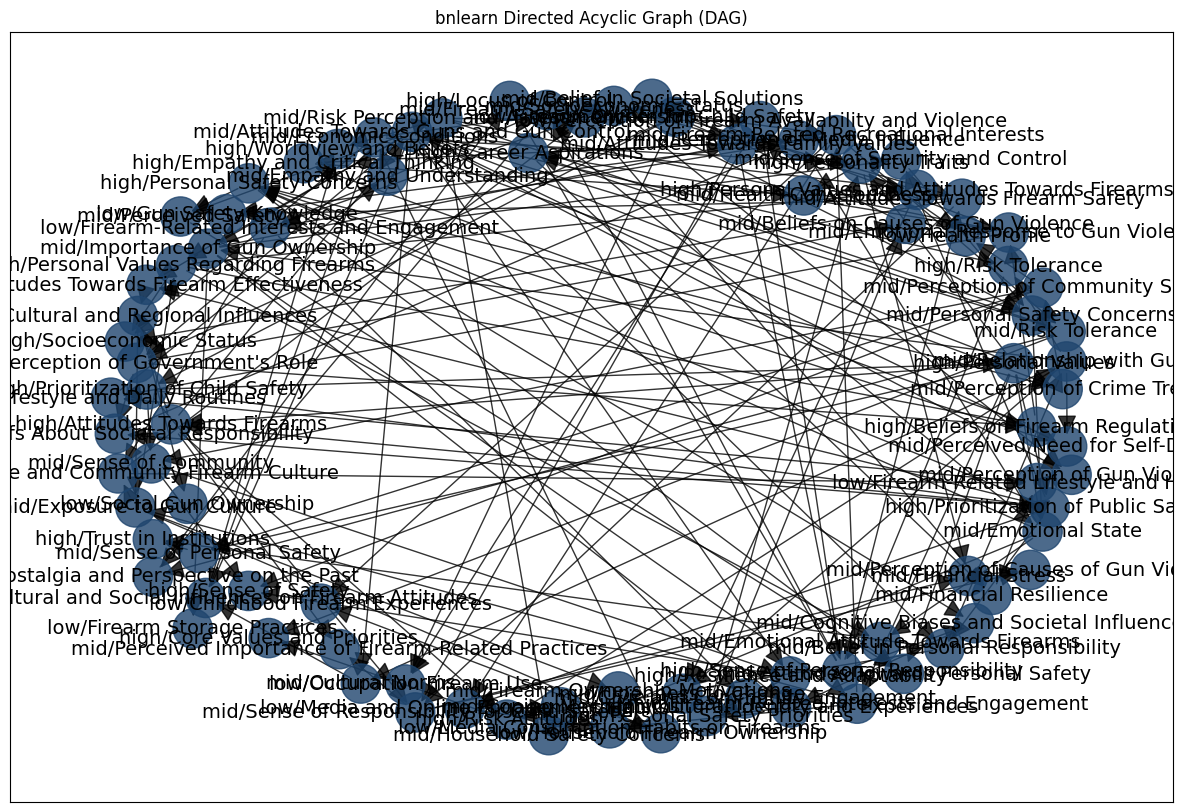

[bnlearn] >Compute edge strength with [chi_square]
[bnlearn] >Edge [high/Locus of Control <-> mid/Emotional State] [P=0.411663] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [high/Personal Values <-> mid/Emotional State] [P=0.210999] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [high/Personal Safety Priorities <-> mid/Beliefs on Causes of Gun Violence] [P=0.0856534] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [high/Beliefs on Firearm Regulations <-> mid/Emotional Response to Gun Violence] [P=0.0923096] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [mid/Concern for Child Safety <-> mid/Attitudes Towards Family Values] [P=0.4889] is excluded because it was not significant (P<0.05) with [chi_square]
[bnlearn] >Edge [mid/Concern for Child Safety <-> low/Occupation Firearm Use] [P=0.429678] is excluded because it was not significa

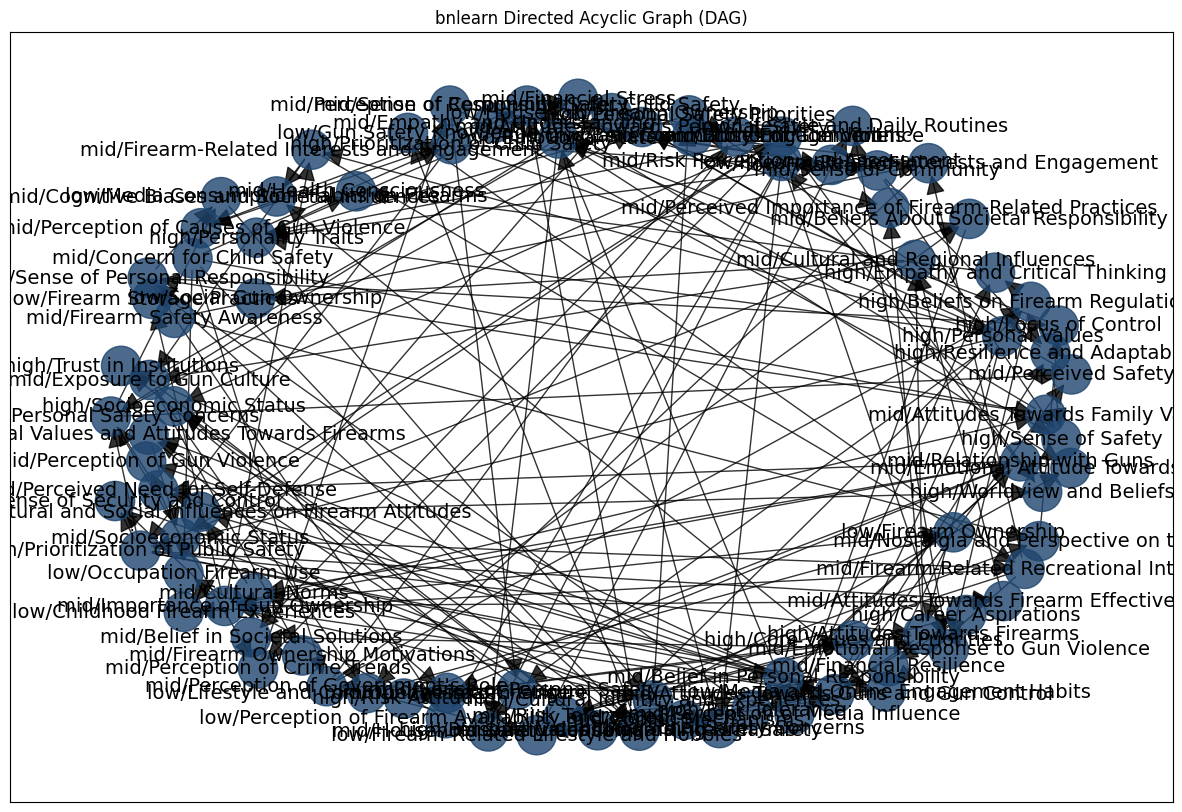

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.


[datazets] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[datazets] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[datazets] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[datazets] >WARNING> Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
[datazets] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[datazets] >WARNING> Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
[datazets] >WARNING> Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
[datazets] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.


[bnlearn] >CPD of high/Personal Values Regarding Firearms:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of high/Socioeconomic Status:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of high/Personal Values and Attitudes Towards Firearms:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of high/Beliefs on Firearm Regulations:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of mid/Emotional Attitude Towards Firearms:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of high/Attitudes Towards Firearms:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of high/Risk Attitudes:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >CPD of mid/Cultural and Re

  0%|          | 0/72 [00:00<?, ?it/s]

[bnlearn]> Remaining columns for inference: 15


  1%|▏         | 1/72 [00:03<04:08,  3.50s/it]

[bnlearn]> Remaining columns for inference: 15


  3%|▎         | 2/72 [00:07<04:09,  3.57s/it]

[bnlearn]> Remaining columns for inference: 15


  4%|▍         | 3/72 [00:10<04:04,  3.55s/it]

[bnlearn]> Remaining columns for inference: 15


  6%|▌         | 4/72 [00:15<04:28,  3.95s/it]

[bnlearn]> Remaining columns for inference: 15


  7%|▋         | 5/72 [00:19<04:43,  4.22s/it]

[bnlearn]> Remaining columns for inference: 15


  8%|▊         | 6/72 [00:23<04:17,  3.90s/it]

[bnlearn]> Remaining columns for inference: 15


 10%|▉         | 7/72 [00:26<03:59,  3.69s/it]

[bnlearn]> Remaining columns for inference: 15


 11%|█         | 8/72 [00:30<03:53,  3.65s/it]

[bnlearn]> Remaining columns for inference: 15


 12%|█▎        | 9/72 [00:35<04:35,  4.37s/it]

[bnlearn]> Remaining columns for inference: 15


 12%|█▎        | 9/72 [00:38<04:28,  4.27s/it]


KeyboardInterrupt: 

In [12]:
for _ in range(1):
    # param_model = get_bn(df, method='hc', score='bds')
    Xtest = bn.sampling(param_model, 10)
    cols = Xtest.columns
    variables=[col for col in cols if col.startswith('mid') or col.startswith('high')]
    for var in tqdm(variables):
        Pout = bn.predict(param_model, df[[col for col in cols if col not in variables]], variables=[var])
        df[var] = Pout[var]
        raw_df[var] = Pout[var]
    
    # param_model = get_bn(df)


In [31]:
raw_df

user  high/Personal Values Regarding Firearms  \
0    2820                                        2   
1    3718                                        2   
2     362                                        2   
3    1758                                        2   
4     124                                        2   
..    ...                                      ...   
389   101                                        2   
390  1020                                        2   
391  3541                                        2   
392   303                                        2   
393  1727                                        2   

     high/Attitudes Towards Firearms  high/Personality Traits  \
0                                  2                        2   
1                                  2                        2   
2                                  2                        2   
3                                  2                        2   
4                                  2                        2   
..                               ...                      ...   
389                                2                        2   
390                                2                        2   
391                                2                        2   
392                                2                        2   
393                                2                        2   

     high/Cultural and Social Influences on Firearm Attitudes  \
0                                                    3          
1                                                    3          
2                                                    3          
3                                                    3          
4                                                    3          
..                                                 ...          
389                                                  3          
390                                                  3          
391                                                  3          
392                                                  3          
393                                                  3          

     high/Prioritization of Child Safety  high/Risk Tolerance  \
0                                      1                    2   
1                                      1                    2   
2                                      1                    2   
3                                      1                    2   
4                                      1                    2   
..                                   ...                  ...   
389                                    1                    2   
390                                    1                    2   
391                                    1                    2   
392                                    1                    2   
393                                    1                    2   

     high/Sense of Safety  high/Socioeconomic Status  \
0                       2                          2   
1                       2                          2   
2                       2                          2   
3                       2                          2   
4                       2                          2   
..                    ...                        ...   
389                     2                          2   
390                     2                          2   
391                     2                          2   
392                     2                          2   
393                     2                          2   

     high/Worldview and Beliefs  ...  low/Health Profile  \
0                             3  ...                   2   
1                             3  ...                   2   
2                             3  ...                   2   
3                             3  ...                   2   
4                             3  ...    

In [32]:
for var in raw_df.columns:
    if '/' not in var or var not in idx2opt_mapping: continue
    try:
        raw_df[var] = raw_df[var].apply(lambda x: idx2opt_mapping[var][x])
    except:
        print(var)
        print(idx2opt_mapping[var])

raw_df

user high/Personal Values Regarding Firearms  \
0    2820                    values public safety   
1    3718                    values public safety   
2     362                    values public safety   
3    1758                    values public safety   
4     124                    values public safety   
..    ...                                     ...   
389   101                    values public safety   
390  1020                    values public safety   
391  3541                    values public safety   
392   303                    values public safety   
393  1727                    values public safety   

    high/Attitudes Towards Firearms high/Personality Traits  \
0                          anti-gun             risk-taking   
1                          anti-gun             risk-taking   
2                          anti-gun             risk-taking   
3                          anti-gun             risk-taking   
4                          anti-gun             risk-taking   
..                              ...                     ...   
389                        anti-gun             risk-taking   
390                        anti-gun             risk-taking   
391                        anti-gun             risk-taking   
392                        anti-gun             risk-taking   
393                        anti-gun             risk-taking   

    high/Cultural and Social Influences on Firearm Attitudes  \
0                                      neutral culture         
1                                      neutral culture         
2                                      neutral culture         
3                                      neutral culture         
4                                      neutral culture         
..                                                 ...         
389                                    neutral culture         
390                                    neutral culture         
391                                    neutral culture         
392                                    neutral culture         
393                                    neutral culture         

    high/Prioritization of Child Safety high/Risk Tolerance  \
0         high priority on child safety  low risk tolerance   
1         high priority on child safety  low risk tolerance   
2         high priority on child safety  low risk tolerance   
3         high priority on child safety  low risk tolerance   
4         high priority on child safety  low risk tolerance   
..                                  ...                 ...   
389       high priority on child safety  low risk tolerance   
390       high priority on child safety  low risk tolerance   
391       high priority on child safety  low risk tolerance   
392       high priority on child safety  low risk tolerance   
393       high priority on child safety  low risk tolerance   

    high/Sense of Safety  high/Socioeconomic Status  \
0    low sense of safety  high socioeconomic status   
1    low sense of safety  high socioeconomic status   
2    low sense of safety  high socioeconomic status   
3    low sense of safety  high socioeconomic status   
4    low sense of safety  high socioeconomic status   
..                   ...                        ...   
389  low sense of safety  high socioeconomic status   
390  low sense of safety  high socioeconomic status   
391  low sense of safety  high socioeconomic status   
392  low sense of safety  high socioeconomic status   
393  low sense of safety  high socioeconomic status   

    high/Worldview and Beliefs  ...                       low/Health Profile  \
0            neutral worldview  ...        poor health with limited coverage   
1            neutral worldview  ...        poor health with limited coverage   
2            neutral worldview  ...        poor health with limited coverage   
3            neutral worldview  ...        poor health with limited coverage   
4            neutral wor

# Output raw_df

In [33]:

for _, row in raw_df.iterrows():
    user = str(row['user'])
    personas = categorized_data[user]
    for idx, p in enumerate(personas):
        val = row[f"{p['level']}/{p['name']}"]
        # mapping = idx2opt_mapping[f"{p['level']}/{p['name']}"]
        # new_val = mapping[val]
        # categorized_data[user][idx]['inferred_value'] = new_val
        categorized_data[user][idx]['inferred_value'] = val

new_persona_filename = 'opinions_qa/persona_val/American_Trends_Panel_W26/date0830_personas_testonly_haiku_bn_hcbds_em7.json'

with open(new_persona_filename, 'w') as f:
    json.dump(categorized_data, f, indent=4)

# Temp General

In [34]:
# import os
# os.chdir("/home/ubuntu/code/pump_post_midterm/pump")

# import json
# import bnlearn as bn
# import pandas as pd
# import networkx as nx
# from tqdm import tqdm


# for score in tqdm(['k2']):

#     persona_filename = 'opinions_qa/persona_val/American_Trends_Panel_W26/date0729_midterm_personas_full_sonnet.json'

#     with open(persona_filename, 'r') as f:
#         data = json.load(f)
#     data[list(data.keys())[0]]

#     # clean data

#     def clean(data):
#         for user in data.keys():
#             personas = data[user]
#             clean = []
#             for p in personas:
#                 inf_val = p['inferred_value']
#                 cands = p['candidate_values']
#                 if inf_val not in cands:
#                     if inf_val[1:-1] in cands and all(_ in ['\'', '\"'] for _ in [inf_val[0], inf_val[-1]]):
#                         p['inferred_value'] = inf_val[1:-1]
#                         clean.append(p)
#                 else:
#                     clean.append(p)
#             data[user] = clean

#     clean(data)

#     # categorize_data

#     idx2opt_mapping = {}
#     opt2idx_mapping = {}

#     for persona in data[list(data.keys())[0]]:
#         p_name = persona['name']
#         cands = persona['candidate_values']
#         idx2opt = {k+1: v for k, v in enumerate(cands)}  # 0 for potential NAs
#         idx2opt[0] = "Unknown"
#         idx2opt_mapping[p_name] = idx2opt
#         opt2idx_mapping[p_name] = {v: k for k, v in idx2opt.items()}

#     def categorize(data):
#         for user in data:
#             personas = data[user]
#             clean = []
#             for p in personas:
#                 p_name = p['name']
#                 inf_val = p['inferred_value']
#                 p['inferred_value'] = opt2idx_mapping[p_name][inf_val]
#                 clean.append(p)
#             data[user] = clean

#     categorize(data)



#     def get_bn(df, method, score):

#         model = bn.structure_learning.fit(df, methodtype=method, scoretype=score)
#         # Plot detected DAG
#         pos = nx.spring_layout(model['adjmat'])
#         # G = bn.plot(model, pos=pos)
#         # dirs = []
#         # for edge in G['edge_properties']:
#         #     s, t = edge
#         #     s = s.split('/')[0]
#         #     t = t.split('/')[0]
#         #     dirs.append(f"{s}_{t}")
#         # from collections import Counter
#         # sorted(Counter(dirs).items())


#         # Compute edge strength using chi-square independence test
#         model1 = bn.independence_test(model, df, alpha=0.05, prune=True)
#         pos = nx.spring_layout(model['adjmat'])
#         # G1 = bn.plot(model, pos=pos)
#         # dirs = []
#         # for edge in G1['edge_properties']:
#         #     s, t = edge
#         #     s = s.split('/')[0]
#         #     t = t.split('/')[0]
#         #     dirs.append(f"{s}_{t}")
#         # from collections import Counter
#         # sorted(Counter(dirs).items())


#         param_model = bn.parameter_learning.fit(model1, df)

#         return param_model



#     res = []
#     for user in data.keys():
#         entry = {'user': user}
#         for persona in data[user]:
#             entry[f"{persona['level']}/{persona['name']}"] = persona['inferred_value']
#         res.append(entry)

#     raw_df = pd.DataFrame(res)
#     raw_df.fillna(0, inplace=True)
#     raw_df = raw_df.astype(int)
#     df = raw_df[[_ for _ in raw_df.columns if _ != "user"]]
#     df

#     param_model = get_bn(df, method='hc', score=score)

#     for _ in range(1):
#         Xtest = bn.sampling(param_model, 10)
#         cols = Xtest.columns
#         variables=[col for col in cols if col.startswith('mid') or col.startswith('high')]
#         for var in tqdm(variables):
#             Pout = bn.predict(param_model, df[[col for col in cols if col not in variables]], variables=[var])
#             df[var] = Pout[var]
#             raw_df[var] = Pout[var]
        
#         # param_model = get_bn(df)

#     for _, row in raw_df.iterrows():
#         user = str(row['user'])
#         personas = data[user]
#         for idx, p in enumerate(personas):
#             val = row[f"{p['level']}/{p['name']}"]
#             mapping = idx2opt_mapping[p['name']]
#             new_val = mapping[val]
#             data[user][idx]['inferred_value'] = new_val

#     new_persona_filename = f'opinions_qa/persona_val/American_Trends_Panel_W26/date0826_personas_full_sonnet_bn_hc{score}.json'

#     with open(new_persona_filename, 'w') as f:
#         json.dump(data, f, indent=4)